**Генерирање на податочно множество од симулирани бранови - BNS бранови**

Во овој код се креира template bank, односно се креира листа од примероци кои подоцна ќе се користат како дополнителни симулирани бранови за CNN мрежата. Избраните параметри за template bank - BNS сигнали се следните

* масата за двете неутронски ѕвезди од 1 до 2.5 соларни маси со чекор 0.1
* вредности на спинот од -0.8 до 0.8 со чекор 0.4
* однос помеѓу масите (mass ratio) m1/m2 <= 10

In [1]:
! pip install -q 'lalsuite==7.11' 'PyCBC==2.0.5'

In [2]:
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
import pycbc.catalog
from pycbc.types import TimeSeries
import numpy as np
import pandas as pd
import os
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter
from pycbc.filter import sigma

In [3]:
GWTC1_events = ["GW150914", "GW151012", "GW151226", "GW170104", "GW170608", "GW170729", "GW170809", "GW170814", "GW170817",
               "GW170818", "GW170823"]

In [4]:
strain_H_data = []
strain_L_data = []
strain_V_data = []

In [5]:
events_H = []
events_L = []
events_V = []

In [6]:
for gwtc1_event in GWTC1_events:
    merger = pycbc.catalog.Merger(gwtc1_event, source='gwtc-1')
    strain_H = merger.strain('H1')
    strain_L = merger.strain('L1')
    
    strain_H = highpass(strain_H, 15.0)
    strain_H = resample_to_delta_t(strain_H, 1.0/2048)
    strain_L = highpass(strain_L, 15.0)
    strain_L = resample_to_delta_t(strain_L, 1.0/2048)
    
    if gwtc1_event in ["GW150914", "GW151012", "GW151226", "GW170104", "GW170608", "GW170823"]: #za ovie nastani nema raboteno Virgo detektorot
        strain_V_array = np.full(65536, np.nan)
        strain_V_data.append(strain_V_array)
    else:
        strain_V = merger.strain('V1')
        strain_V = highpass(strain_V, 15.0)
        strain_V = resample_to_delta_t(strain_V, 1.0/2048)
        strain_V_array = strain_V.numpy()
        strain_V_data.append(strain_V_array)
        events_V.append(gwtc1_event)
    
    strain_H_array = strain_H.numpy()
    strain_H_data.append(strain_H_array)
    strain_L_array = strain_L.numpy()
    strain_L_data.append(strain_L_array)
    events_H.append(gwtc1_event)
    events_L.append(gwtc1_event)

In [7]:
strain_H_data = [array for array in strain_H_data if not np.isnan(array).any()]
strain_L_data = [array for array in strain_L_data if not np.isnan(array).any()]
strain_V_data = [array for array in strain_V_data if not np.isnan(array).any()]

In [8]:
NS_masses = []

start_mass = 1
end_mass = 2.5

step = 0.1

current_mass = start_mass
while current_mass <= end_mass:
    NS_masses.append(current_mass)
    current_mass += step

In [9]:
spins = []

start_spin = -0.8
end_spin = 0.8

step = 0.4

current_spin = start_spin
while current_spin <= end_spin:
    spins.append(current_spin)
    current_spin += step

In [28]:
templates_BNS_1 = []

In [29]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[0] #m1=1
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_1.append(waveform)

In [30]:
print(len(templates_BNS_1))

375


In [31]:
template_backup1 = templates_BNS_1

In [32]:
print(templates_BNS_1[0].size)

8388608


Треба да се намали бројот на точки на 2048 за да биде настанот 1s долг.

In [33]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_1:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_1 = modified_waveforms

In [34]:
print(len(templates_BNS_1[0]))

2048


In [35]:
ts = TimeSeries(templates_BNS_1[0], delta_t=1.0/2048)

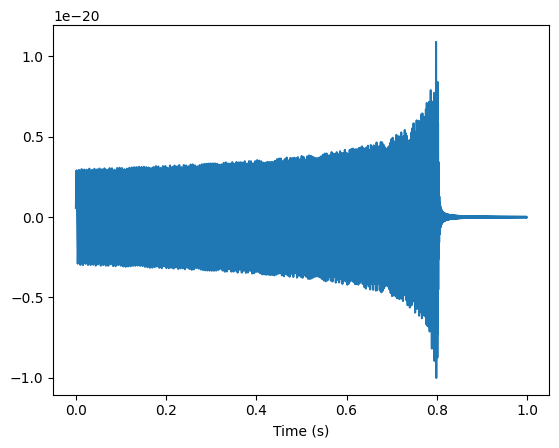

In [36]:
pylab.plot(ts.sample_times, ts)
pylab.xlabel('Time (s)')
pylab.show()

In [38]:
output_dir = '/kaggle/working/BNS_events'
os.makedirs(output_dir, exist_ok=True)

event_paths_1 = []
event_targets_1 = []

i = 0

for waveform in templates_BNS_1:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_1.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_1.append('BNS')

  i = i+1

labels = np.array([event_paths_1, event_targets_1]).T
np.save(os.path.join(output_dir, 'labels1.npy'), labels)

In [39]:
print(i)

375


In [23]:
i = 375

In [44]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events", 'zip', output_dir)


'/kaggle/working/BNS_events.zip'

In [14]:
templates_BNS_2 = []

In [15]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[1] #m1=1.1
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_2.append(waveform)

In [16]:
print(len(templates_BNS_2))

350


In [18]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_2:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_2 = modified_waveforms

In [20]:
print(len(templates_BNS_2[0]))

2048


In [24]:
output_dir = '/kaggle/working/BNS_events2'
os.makedirs(output_dir, exist_ok=True)

event_paths_2 = []
event_targets_2 = []

for waveform in templates_BNS_2:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_2.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_2.append('BNS')

  i = i+1

labels = np.array([event_paths_2, event_targets_2]).T
np.save(os.path.join(output_dir, 'labels2.npy'), labels)

In [25]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events2", 'zip', output_dir)

'/kaggle/working/BNS_events2.zip'

In [26]:
print(i)

725


In [18]:
i = 725

In [13]:
templates_BNS_3 = []

In [14]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[2] #m1=1.2
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_3.append(waveform)

In [15]:
print(len(templates_BNS_3))

325


In [16]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_3:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_3 = modified_waveforms

In [17]:
print(len(templates_BNS_3[0]))

2048


In [19]:
output_dir = '/kaggle/working/BNS_events3'
os.makedirs(output_dir, exist_ok=True)

event_paths_3 = []
event_targets_3 = []

for waveform in templates_BNS_3:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_3.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_3.append('BNS')

  i = i+1

labels = np.array([event_paths_3, event_targets_3]).T
np.save(os.path.join(output_dir, 'labels3.npy'), labels)

In [20]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events3", 'zip', output_dir)

'/kaggle/working/BNS_events3.zip'

In [21]:
print(i)

1050


In [10]:
i = 1050

In [11]:
templates_BNS_4 = []

In [12]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[3] #m1=1.3
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_4.append(waveform)

In [13]:
print(len(templates_BNS_4))

300


In [14]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_4:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_4 = modified_waveforms

In [15]:
print(len(templates_BNS_4[0]))

2048


In [16]:
output_dir = '/kaggle/working/BNS_events4'
os.makedirs(output_dir, exist_ok=True)

event_paths_4 = []
event_targets_4 = []

for waveform in templates_BNS_4:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_4.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_4.append('BNS')

  i = i+1

labels = np.array([event_paths_4, event_targets_4]).T
np.save(os.path.join(output_dir, 'labels4.npy'), labels)

In [17]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events4", 'zip', output_dir)

'/kaggle/working/BNS_events4.zip'

In [18]:
print(i)

1350


In [19]:
i = 1350

In [20]:
templates_BNS_5 = []

In [22]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[4] #m1=1.4
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_5.append(waveform)

In [23]:
print(len(templates_BNS_5))

275


In [24]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_5:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_5 = modified_waveforms

In [25]:
print(len(templates_BNS_5[0]))

2048


In [26]:
output_dir = '/kaggle/working/BNS_events5'
os.makedirs(output_dir, exist_ok=True)

event_paths_5 = []
event_targets_5 = []

for waveform in templates_BNS_5:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_5.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_5.append('BNS')

  i = i+1

labels = np.array([event_paths_5, event_targets_5]).T
np.save(os.path.join(output_dir, 'labels5.npy'), labels)

In [27]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events5", 'zip', output_dir)

'/kaggle/working/BNS_events5.zip'

In [28]:
print(i)

1625


In [11]:
i = 1625

In [12]:
templates_BNS_6 = []

In [13]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[5] #m1=1.5
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_6.append(waveform)

In [14]:
print(len(templates_BNS_6))

250


In [15]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_6:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_6 = modified_waveforms

In [16]:
print(len(templates_BNS_6[0]))

2048


In [17]:
output_dir = '/kaggle/working/BNS_events6'
os.makedirs(output_dir, exist_ok=True)

event_paths_6 = []
event_targets_6 = []

for waveform in templates_BNS_6:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_6.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_6.append('BNS')

  i = i+1

labels = np.array([event_paths_6, event_targets_6]).T
np.save(os.path.join(output_dir, 'labels6.npy'), labels)

In [18]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events6", 'zip', output_dir)

'/kaggle/working/BNS_events6.zip'

In [19]:
print(i)

1875


In [20]:
i = 1875

In [21]:
templates_BNS_7 = []

In [23]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[6] #m1=1.6
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_7.append(waveform)

In [24]:
print(len(templates_BNS_7))

225


In [25]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_7:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_7 = modified_waveforms

In [26]:
print(len(templates_BNS_7[0]))

2048


In [27]:
output_dir = '/kaggle/working/BNS_events7'
os.makedirs(output_dir, exist_ok=True)

event_paths_7 = []
event_targets_7 = []

for waveform in templates_BNS_7:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_7.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_7.append('BNS')

  i = i+1

labels = np.array([event_paths_7, event_targets_7]).T
np.save(os.path.join(output_dir, 'labels7.npy'), labels)

In [28]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events7", 'zip', output_dir)

'/kaggle/working/BNS_events7.zip'

In [29]:
print(i)

2100


In [30]:
i = 2100

In [31]:
templates_BNS_8 = []

In [32]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[7] #m1=1.7
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_8.append(waveform)

In [33]:
print(len(templates_BNS_8))

200


In [34]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_8:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_8 = modified_waveforms

In [35]:
print(len(templates_BNS_8[0]))

2048


In [36]:
output_dir = '/kaggle/working/BNS_events8'
os.makedirs(output_dir, exist_ok=True)

event_paths_8 = []
event_targets_8 = []

for waveform in templates_BNS_8:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_8.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_8.append('BNS')

  i = i+1

labels = np.array([event_paths_8, event_targets_8]).T
np.save(os.path.join(output_dir, 'labels8.npy'), labels)

In [37]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events8", 'zip', output_dir)

'/kaggle/working/BNS_events8.zip'

In [38]:
print(i)

2300


In [39]:
i = 2300

In [40]:
templates_BNS_9 = []

In [41]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[8] #m1=1.8
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_9.append(waveform)

In [42]:
print(len(templates_BNS_9))

175


In [43]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_9:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_9 = modified_waveforms

In [44]:
print(len(templates_BNS_9[0]))

2048


In [45]:
output_dir = '/kaggle/working/BNS_events9'
os.makedirs(output_dir, exist_ok=True)

event_paths_9 = []
event_targets_9 = []

for waveform in templates_BNS_9:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_9.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_9.append('BNS')

  i = i+1

labels = np.array([event_paths_9, event_targets_9]).T
np.save(os.path.join(output_dir, 'labels9.npy'), labels)

In [46]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events9", 'zip', output_dir)

'/kaggle/working/BNS_events9.zip'

In [47]:
print(i)

2475


In [10]:
i = 2475

In [11]:
templates_BNS_10 = []

In [12]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[9] #m1=1.9
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_10.append(waveform)

In [13]:
print(len(templates_BNS_10))

150


In [14]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_10:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_10 = modified_waveforms

In [15]:
print(len(templates_BNS_10[0]))

2048


In [16]:
output_dir = '/kaggle/working/BNS_events10'
os.makedirs(output_dir, exist_ok=True)

event_paths_10 = []
event_targets_10 = []

for waveform in templates_BNS_10:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_10.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_10.append('BNS')

  i = i+1

labels = np.array([event_paths_10, event_targets_10]).T
np.save(os.path.join(output_dir, 'labels10.npy'), labels)

In [17]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events10", 'zip', output_dir)

'/kaggle/working/BNS_events10.zip'

In [18]:
print(i)

2625


In [19]:
i = 2625

In [20]:
templates_BNS_11 = []

In [22]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[10] #m1=2
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_11.append(waveform)

In [23]:
print(len(templates_BNS_11))

125


In [24]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_11:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_11 = modified_waveforms

In [25]:
print(len(templates_BNS_11[0]))

2048


In [26]:
output_dir = '/kaggle/working/BNS_events11'
os.makedirs(output_dir, exist_ok=True)

event_paths_11 = []
event_targets_11 = []

for waveform in templates_BNS_11:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_11.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_11.append('BNS')

  i = i+1

labels = np.array([event_paths_11, event_targets_11]).T
np.save(os.path.join(output_dir, 'labels11.npy'), labels)

In [27]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events11", 'zip', output_dir)

'/kaggle/working/BNS_events11.zip'

In [28]:
print(i)

2750


In [29]:
i = 2750

In [30]:
templates_BNS_12 = []

In [32]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[11] #m1=2.1
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_12.append(waveform)

In [33]:
print(len(templates_BNS_12))

100


In [34]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_12:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_12 = modified_waveforms

In [35]:
print(len(templates_BNS_12[0]))

2048


In [36]:
output_dir = '/kaggle/working/BNS_events12'
os.makedirs(output_dir, exist_ok=True)

event_paths_12 = []
event_targets_12 = []

for waveform in templates_BNS_12:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_12.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_12.append('BNS')

  i = i+1

labels = np.array([event_paths_12, event_targets_12]).T
np.save(os.path.join(output_dir, 'labels12.npy'), labels)

In [37]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events12", 'zip', output_dir)

'/kaggle/working/BNS_events12.zip'

In [38]:
print(i)

2850


In [39]:
i = 2850

In [40]:
templates_BNS_13 = []

In [41]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[12] #m1=2.2
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_13.append(waveform)

In [42]:
print(len(templates_BNS_13))

75


In [43]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_13:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_13 = modified_waveforms

In [44]:
print(len(templates_BNS_13[0]))

2048


In [45]:
output_dir = '/kaggle/working/BNS_events13'
os.makedirs(output_dir, exist_ok=True)

event_paths_13 = []
event_targets_13 = []

for waveform in templates_BNS_13:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_13.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_13.append('BNS')

  i = i+1

labels = np.array([event_paths_13, event_targets_13]).T
np.save(os.path.join(output_dir, 'labels13.npy'), labels)

In [46]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events13", 'zip', output_dir)

'/kaggle/working/BNS_events13.zip'

In [47]:
print(i)

2925


In [48]:
i = 2925

In [49]:
templates_BNS_14 = []

In [50]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[13] #m1=2.3
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_14.append(waveform)

In [51]:
print(len(templates_BNS_14))

50


In [52]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_14:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_14 = modified_waveforms

In [53]:
print(len(templates_BNS_14[0]))

2048


In [54]:
output_dir = '/kaggle/working/BNS_events14'
os.makedirs(output_dir, exist_ok=True)

event_paths_14 = []
event_targets_14 = []

for waveform in templates_BNS_14:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_14.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_14.append('BNS')

  i = i+1

labels = np.array([event_paths_14, event_targets_14]).T
np.save(os.path.join(output_dir, 'labels14.npy'), labels)

In [55]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events14", 'zip', output_dir)

'/kaggle/working/BNS_events14.zip'

In [56]:
print(i)

2975


In [57]:
i = 2975

In [58]:
templates_BNS_15 = []

In [59]:
strain_H_event = TimeSeries(strain_H_data[8], delta_t=1.0/2048)
strain_H_event = strain_H_event.crop(2, 2) #se ostranuvaat po 2s na pochetokot i krajot za da se otstranat diskontinuitetite
psd = strain_H_event.psd(4) #presmetka na PSD se zemanje na primeroci po 4s preku Welch-ov metod
psd = interpolate(psd, strain_H_event.delta_f) #interpolacija na PSD za da ima match so event data
psd = inverse_spectrum_truncation(psd, int(4*strain_H_event.sample_rate), low_frequency_cutoff=15) #1/PSD e filter so efektivna dolzhina od 4, ne se zemaat frekv. pod 15 deka vrz signalot beshe izvrshen highpass filter
#generiranje na template preku oficijalen nastan za da ne se generiraat premnogu tochki koi se generiraat po default
m1 = NS_masses[14] #m1=2.4
for m2 in np.arange(m1, 2.5, 0.1):
    if m1 >= m2:
        mass_ratio = m1/m2
    else:
        mass_ratio = m2/m1
    if mass_ratio <= 10:
        for spin1 in spins:
            for spin2 in spins:
                hp, hc = get_td_waveform(approximant="TaylorF2",
                     mass1=m1,
                     mass2=m2,
                     spin1x=0,
                     spin1y=0,
                     spin1z=spin1,
                     spin2x=0,
                     spin2y=0,
                     spin2z=spin2,                    
                     delta_t=strain_H_event.delta_t,
                     f_lower=10)
                waveform = hp.numpy()
                templates_BNS_15.append(waveform)

In [60]:
print(len(templates_BNS_15))

25


In [61]:
desired_length = 2048

modified_waveforms = []

for waveform in templates_BNS_15:
    if len(waveform) > desired_length:
        modified_waveform = waveform[len(waveform) - desired_length:]
        modified_waveforms.append(modified_waveform)
    else:
        modified_waveforms.append(waveform)

templates_BNS_15 = modified_waveforms

In [62]:
print(len(templates_BNS_15[0]))

2048


In [63]:
output_dir = '/kaggle/working/BNS_events15'
os.makedirs(output_dir, exist_ok=True)

event_paths_15 = []
event_targets_15 = []

for waveform in templates_BNS_15:
  event_name = f'BNS{i + 1}'

  event_dir = os.path.join(output_dir, event_name)
  os.makedirs(event_dir, exist_ok=True)

  np.save(os.path.join(event_dir, f'strain{i + 1}.npy'), waveform)

  event_paths_15.append(os.path.join(event_dir, f'strain{i + 1}.npy'))
  event_targets_15.append('BNS')

  i = i+1

labels = np.array([event_paths_15, event_targets_15]).T
np.save(os.path.join(output_dir, 'labels15.npy'), labels)

In [64]:
import shutil

shutil.make_archive("/kaggle/working/BNS_events15", 'zip', output_dir)

'/kaggle/working/BNS_events15.zip'

In [65]:
print(i)

3000


Генерирани се 3000 BNS настани.